In [36]:
import numpy as np
import os
import pickle

In [37]:
import tensorflow as tf

tf.get_logger().setLevel('ERROR')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [38]:
CHECKPOINTS_DIR_PATH = './checkpoints/'

CLASSIFIER_CHECKPOINT = 'Classifier'
DENOISER_CHECKPOINT = 'Denoiser'
CNN_ENCODER_CHECKPOINT = 'CNN_Encoder'
RNN_DECODER_CHECKPOINT = 'RNN_Decoder'

VOCABULARY_PATH = './vocabulary'
DEMO_DATASET_PATH = './Demo - Dataset'

In [39]:
IMG_HEIGHT = 320
IMG_WIDTH = 320
BATCH_SIZE = 64

In [40]:
import matplotlib.pyplot as plt

def display_image(img, title=''):
    plt.figure(figsize=(20, 5))
    plt.imshow(np.array(img).astype('uint8'), vmax=1)
    plt.axis("off")
    plt.title(title)

def display_encoded_images(x, n):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.array(x[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def display_images(X, n, titles=None):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(np.array(X[i]).astype('uint8'), vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Load dataset

In [41]:
dataset = tf.keras.utils.image_dataset_from_directory(
    DEMO_DATASET_PATH,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
)

# Convert BatchDataset to np array
dataset = np.concatenate(list(dataset.map(lambda x, y: x)))

Found 3 files belonging to 1 classes.


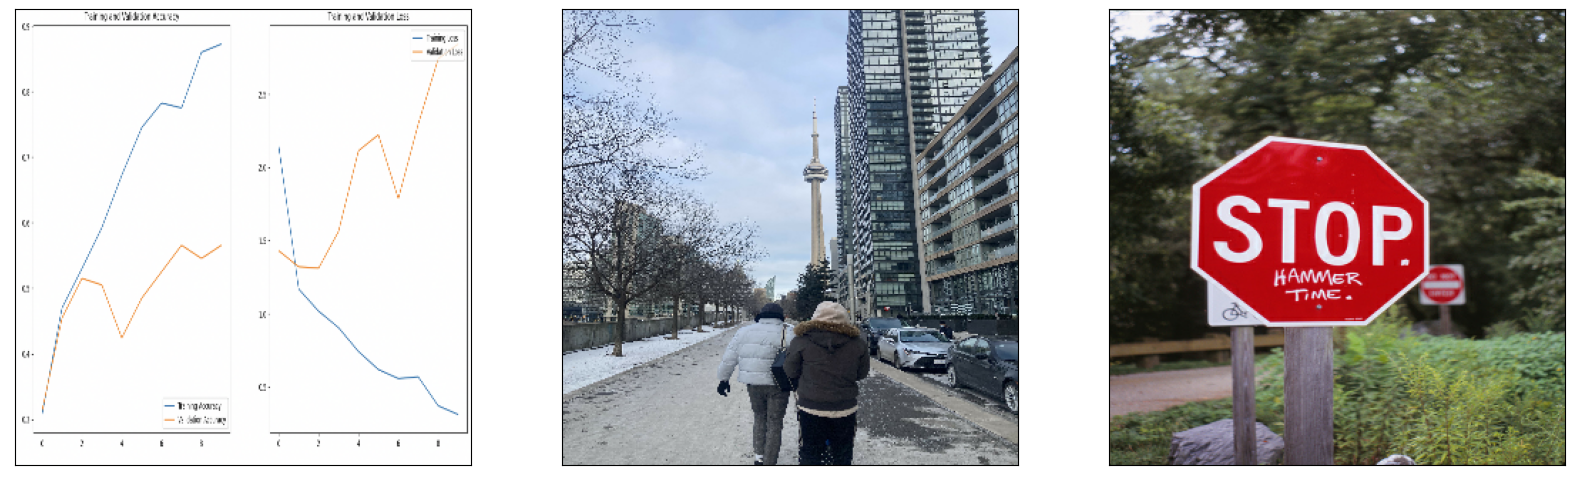

In [42]:
display_images(dataset, len(dataset))

## Classify photos

In [8]:
classifier = tf.keras.models.load_model(os.path.join(CHECKPOINTS_DIR_PATH, CLASSIFIER_CHECKPOINT))
class_names = ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']

In [9]:
predictions = classifier.predict(dataset)

1/1 [==============================] - 0s 87ms/step


In [17]:
photos = []
for prediction, image in zip(predictions, dataset):
    predicted_class = class_names[np.argmax(prediction)]
    if predicted_class != 'Photo':
        continue

    photos.append(image)

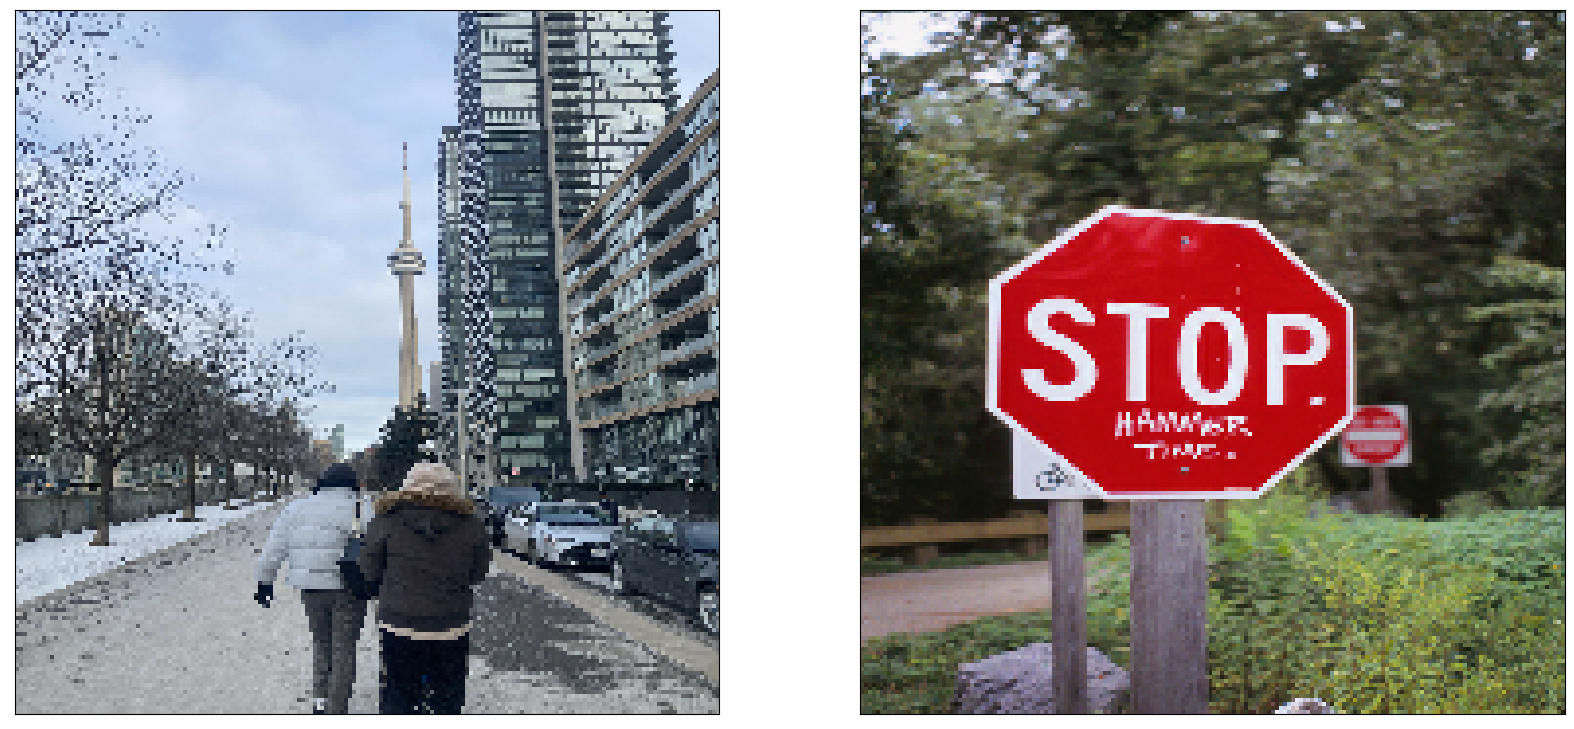

In [18]:
display_images(photos, len(photos))

## Denoiser

In [43]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [44]:
denoiser = tf.keras.models.load_model(
    os.path.join(CHECKPOINTS_DIR_PATH, DENOISER_CHECKPOINT),
    custom_objects={'ssim_loss': ssim_loss}
)

In [45]:
denoiser.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 320, 320, 256)     19456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 160, 160, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 128)     819328    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 80, 80, 128)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 80, 80, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 80, 80, 128)      

In [46]:
photos = tf.keras.layers.Rescaling(1 / 255.)(dataset)
denoised_photos = denoiser(np.array(photos))

In [47]:
denoised_photos[0]

<tf.Tensor: shape=(320, 320, 3), dtype=float32, numpy=
array([[[0.6538271 , 0.6400297 , 0.6441994 ],
        [0.76387477, 0.774501  , 0.7746644 ],
        [0.8461747 , 0.85073864, 0.84848344],
        ...,
        [0.88308805, 0.88530666, 0.8794353 ],
        [0.8380651 , 0.8308989 , 0.826546  ],
        [0.6061548 , 0.58141524, 0.58454126]],

       [[0.71747035, 0.7300995 , 0.73675454],
        [0.9017065 , 0.9041836 , 0.90380603],
        [0.94758123, 0.9449175 , 0.9441302 ],
        ...,
        [0.9800063 , 0.98222715, 0.98306966],
        [0.9606775 , 0.96505344, 0.9653324 ],
        [0.8136767 , 0.81785023, 0.8182326 ]],

       [[0.8224703 , 0.8298426 , 0.84262186],
        [0.948938  , 0.9520363 , 0.9539002 ],
        [0.96334124, 0.9639728 , 0.96482885],
        ...,
        [0.99071026, 0.99210656, 0.9925431 ],
        [0.9851376 , 0.9872546 , 0.9879963 ],
        [0.90538955, 0.91163635, 0.9204228 ]],

       ...,

       [[0.83926207, 0.8581431 , 0.8629427 ],
        [0.94

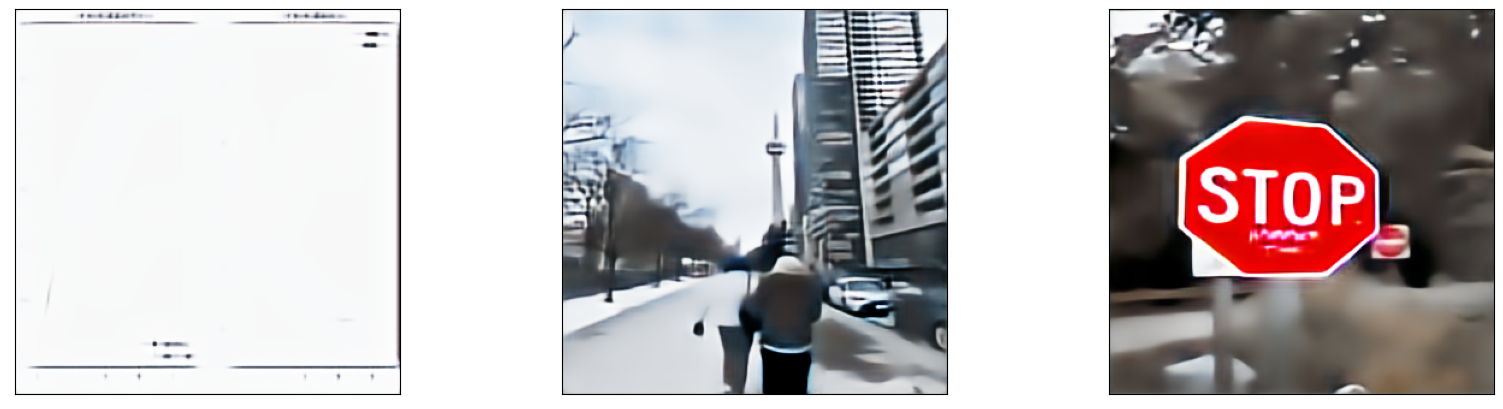

In [49]:
display_encoded_images(denoised_photos, len(denoised_photos))

## Livrable 3

In [50]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [51]:
encoder = tf.keras.models.load_model(os.path.join(CHECKPOINTS_DIR_PATH, CNN_ENCODER_CHECKPOINT))

In [52]:
decoder = tf.keras.models.load_model(os.path.join(CHECKPOINTS_DIR_PATH, RNN_DECODER_CHECKPOINT))

In [53]:
# Load Vocabulary for captioning
with open(VOCABULARY_PATH, 'rb') as file:
    train_captions = pickle.load(file)

caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)


# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(inputs, r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")


# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length
)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary()
)
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True
)

NotFoundError: Graph execution error:

Detected at node 'StringSplit/stack' defined at (most recent call last):
    File "/Users/antoine/miniforge3/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/antoine/miniforge3/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/traitlets/config/application.py", line 978, in launch_instance
      app.start()
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/antoine/miniforge3/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/Users/antoine/miniforge3/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/Users/antoine/miniforge3/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/fd/m1smtkts4nz9q39hqcsb72lh0000gn/T/ipykernel_1496/620672013.py", line 25, in <module>
      tokenizer.adapt(caption_dataset)
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/keras/layers/preprocessing/text_vectorization.py", line 467, in adapt
      super().adapt(data, batch_size=batch_size, steps=steps)
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/keras/engine/base_preprocessing_layer.py", line 258, in adapt
      self._adapt_function(iterator)
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/keras/engine/base_preprocessing_layer.py", line 123, in adapt_step
      self.update_state(data)
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/keras/layers/preprocessing/text_vectorization.py", line 470, in update_state
      self._lookup_layer.update_state(self._preprocess(data))
    File "/Users/antoine/miniforge3/lib/python3.10/site-packages/keras/layers/preprocessing/text_vectorization.py", line 575, in _preprocess
      inputs = tf.strings.split(inputs)
Node: 'StringSplit/stack'
2 root error(s) found.
  (0) NOT_FOUND:  No registered 'ExpandDims' OpKernel for 'GPU' devices compatible with node {{node StringSplit/stack}}
	 (OpKernel was found, but attributes didn't match) Requested Attributes: T=DT_STRING, Tdim=DT_INT32, _XlaHasReferenceVars=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"
	.  Registered:  device='XLA_CPU_JIT'; Tdim in [DT_INT32, DT_INT64]; T in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, 16005131165644881776, DT_UINT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]
  device='DEFAULT'; T in [DT_HALF]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_HALF]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_BFLOAT16]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_BFLOAT16]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_FLOAT]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_FLOAT]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_DOUBLE]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_DOUBLE]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_UINT64]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_UINT64]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_INT64]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_INT64]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_UINT32]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_UINT32]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_UINT16]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_UINT16]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_INT16]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_INT16]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_UINT8]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_UINT8]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_INT8]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_INT8]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_COMPLEX64]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_COMPLEX64]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_COMPLEX128]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_COMPLEX128]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_BOOL]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_BOOL]; Tdim in [DT_INT64]
  device='DEFAULT'; T in [DT_INT32]; Tdim in [DT_INT32]
  device='DEFAULT'; T in [DT_INT32]; Tdim in [DT_INT64]
  device='CPU'; Tdim in [DT_INT32]
  device='CPU'; Tdim in [DT_INT64]

	 [[StringSplit/stack]]
  (1) CANCELLED:  Function was cancelled before it was started
0 successful operations.
0 derived errors ignored. [Op:__inference_adapt_step_16554]

In [54]:
max_length = 7
attention_features_shape = 64


def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(tf.convert_to_tensor(image), 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tf.cast(word_to_index('<start>'), tf.int64)], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder.call(dec_input,
                                                              features,
                                                              hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.cast(tf.expand_dims([predicted_id], 0), tf.int64)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [55]:
def predict(dataset):
    captions = []
    for image in dataset:
        img = tf.convert_to_tensor(image)
        img = tf.keras.layers.Resizing(299, 299)(img)
        img = tf.keras.applications.inception_v3.preprocess_input(img)

        result, attention_plot = evaluate(img)

        captions.append(result)

    return captions

In [56]:
predictions = predict(denoised_photos)
display_images(denoised_photos, len(denoised_photos), predictions)

AttributeError: 'RNN_Decoder' object has no attribute 'reset_state'